# Spotify Charts – Feature Exploration

This notebook loads the processed Spotify tracks dataset and uses the `charts` module
(PCA + clustering helpers) to create statistical and fancy visualisations of the audio features.


### Load the data and the functions

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
from data_visualisation import get_id_list
warnings.filterwarnings('ignore')

from charts import plot_pca_scatter, plot_clustered_pca
from data_visualisation import (
    load_data,
    get_id_list,
    get_track_appearances,
    calculate_track_lifecycle,
    plot_track_rankings,
    plot_time_series,
    plot_weekly_trends,
    plot_track_lifecycle,
    plot_audio_feature_distributions,
    plot_streams_heatmap,
    plot_streams_vs_features,
    plot_correlation_heatmap,
    get_stream_correlations,
    engineer_ml_features,
    split_train_test,
    train_stream_prediction_models,
    plot_prediction_results,
    prepare_classification_data,
    train_classification_models,
    plot_classification_results,
    compare_models,
    plot_feature_importance,
    plot_roc_curves,
    plot_best_confusion_matrix,
    print_summary_insights,
)

sns.set_theme(style="whitegrid")

# DATA LOADING

# Path to the gold features file
DATA_PATH = "data/gold/"

# Load the data
songs = load_data(DATA_PATH)

# Quick overview
songs.head()

,track_id,artist_names,track_name,source,streams,week_date,duration_ms,explicit,artists,id_artists,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,3KkXRkHbMCARz0aVfEt68P,"Post Malone, Swae Lee",Sunflower - Spider-Man: Into the Spider-Verse,Universal Records,34579416,2019-01-17,158040.0,0.0,"['Post Malone', 'Swae Lee']","['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...",...,2.0,-5.574,1.0,0.0466,0.556,0.000000,0.0703,0.913,89.911,4.0
1,7xQAfvXzm3AkraOtGPWIZg,Post Malone,Wow.,Republic Records,29944242,2019-01-17,149547.0,1.0,['Post Malone'],['246dkjvS1zLTtiykXe5h60'],...,11.0,-7.359,0.0,0.2080,0.136,0.000002,0.1030,0.388,99.960,4.0
2,3e9HZxeyfWwjeyPAMmWSSQ,Ariana Grande,"thank u, next",Republic Records,27807232,2019-01-17,207320.0,1.0,['Ariana Grande'],['66CXWjxzNUsdJxJ2JdwvnR'],...,1.0,-5.634,1.0,0.0658,0.229,0.000000,0.1010,0.412,106.966,4.0
3,5p7ujcrUXASCNwRaWNHR1C,Halsey,Without Me,Capitol Records,27138512,2019-01-17,201661.0,1.0,['Halsey'],['26VFTg2z8YR0cCuwLzESi2'],...,6.0,-7.050,1.0,0.0705,0.297,0.000009,0.0936,0.533,136.041,4.0
4,5iwz1NiezX7WWjnCgY5TH4,"Pedro Capó, Farruko",Calma - Remix,Sony Music Latin,22816097,2019-01-17,238200.0,0.0,"['Pedro Capó', 'Farruko']","['4QVBYiagIaa6ZGSPMbybpy', '329e4yvIujISKGKz1B...",...,11.0,-4.218,0.0,0.0524,0.323,0.000000,0.1430,0.761,126.899,4.0


# Time-Series Analysis and Track Rankings


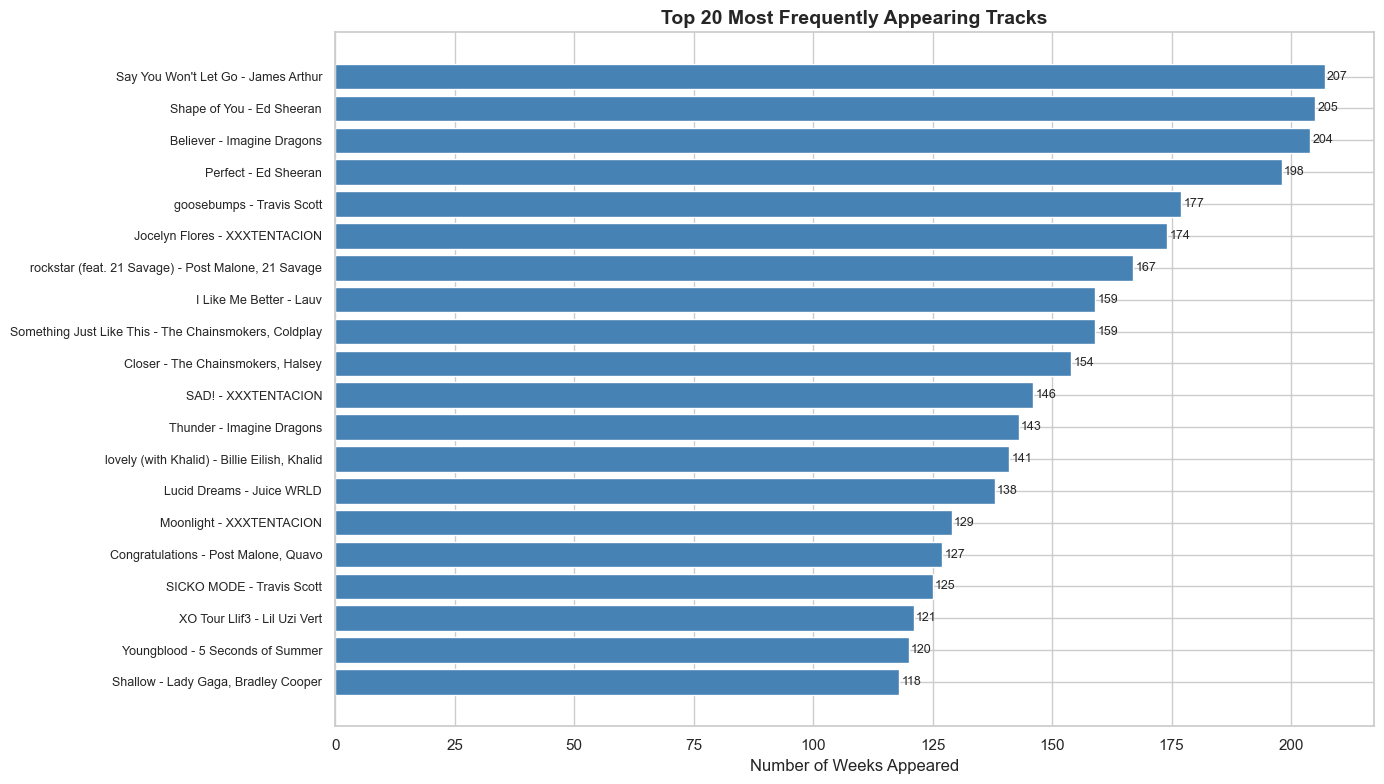


Total unique tracks: 2003
Total track-week combinations: 34591

Top 5 tracks by appearance count:
                track_name     artist_names  appearance_count   avg_streams
1507  Say You Won't Let Go     James Arthur               207  6.584077e+06
1947          Shape of You       Ed Sheeran               205  1.293260e+07
218               Believer  Imagine Dragons               204  7.659177e+06
241                Perfect       Ed Sheeran               198  7.913984e+06
1696            goosebumps     Travis Scott               177  6.308724e+06


In [16]:
# Ranking of most appearing track IDs
track_appearances = get_track_appearances(songs)
top_tracks = plot_track_rankings(track_appearances, top_n=20)

print(f"\nTotal unique tracks: {songs['track_id'].nunique()}")
print(f"Total track-week combinations: {len(songs)}")
print(f"\nTop 5 tracks by appearance count:")
print(top_tracks[['track_name', 'artist_names', 'appearance_count', 'avg_streams']].head())


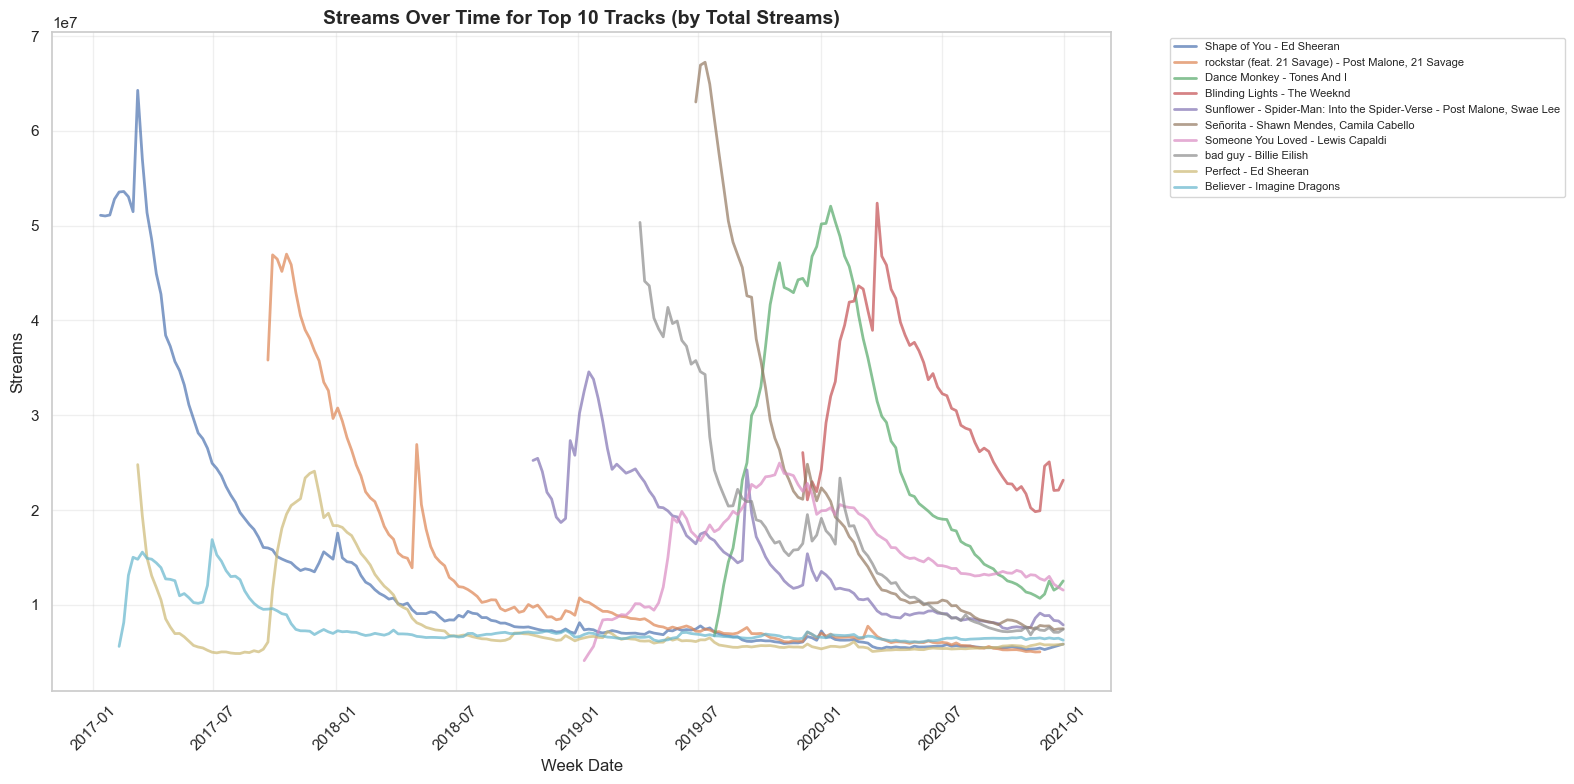

In [17]:
# Time series: Streams per track ID over weeks
plot_time_series(songs, track_appearances, top_n=10, by='total_streams')


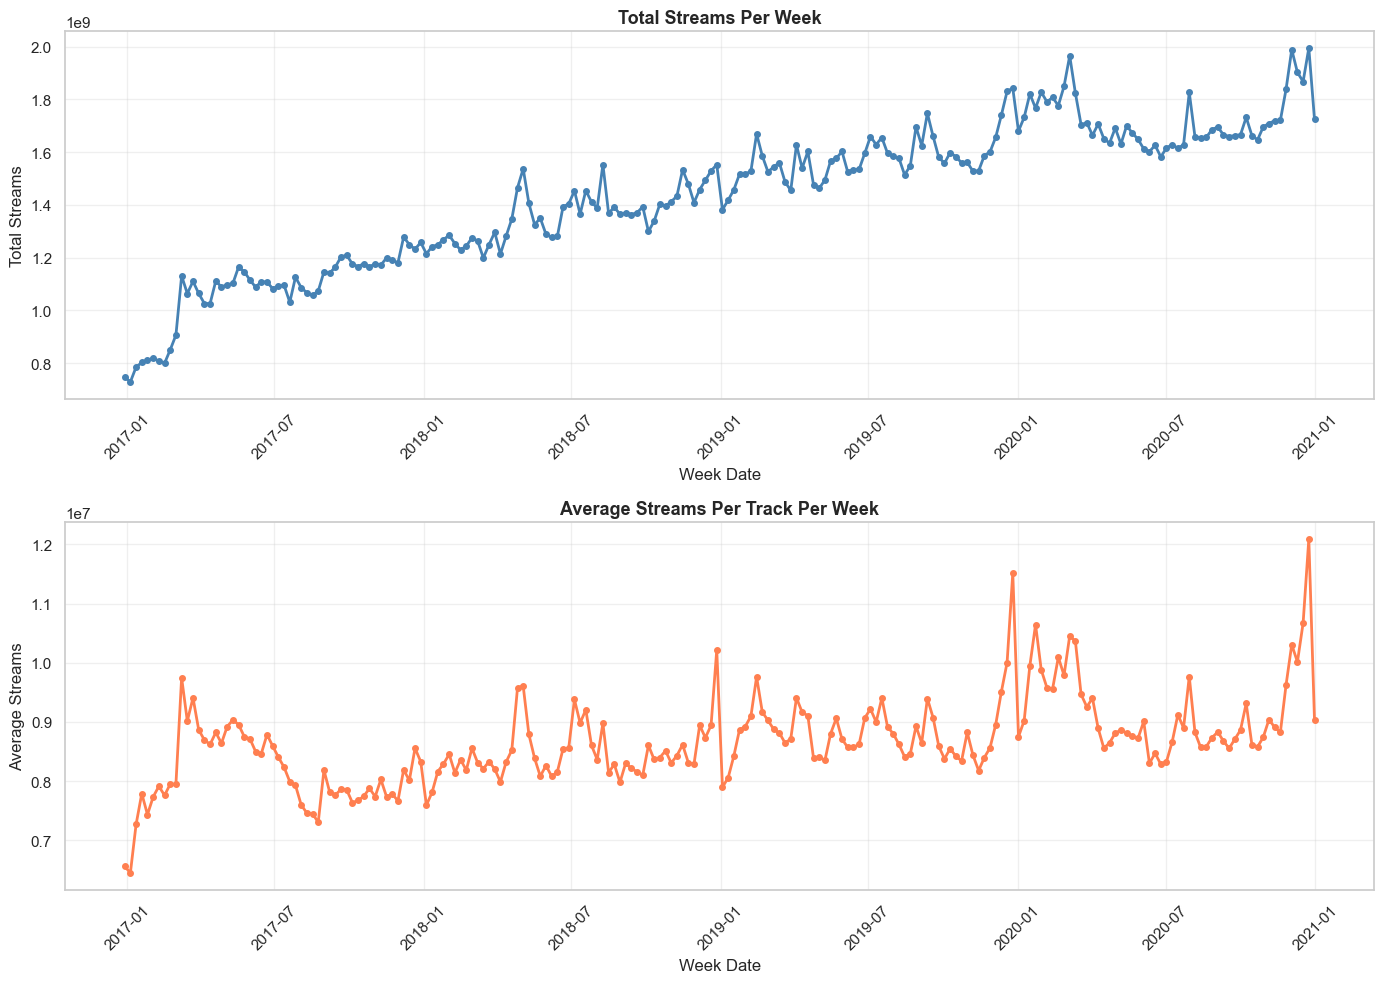

In [18]:
# Aggregate trends: Total and average streams per week
weekly_stats = plot_weekly_trends(songs)


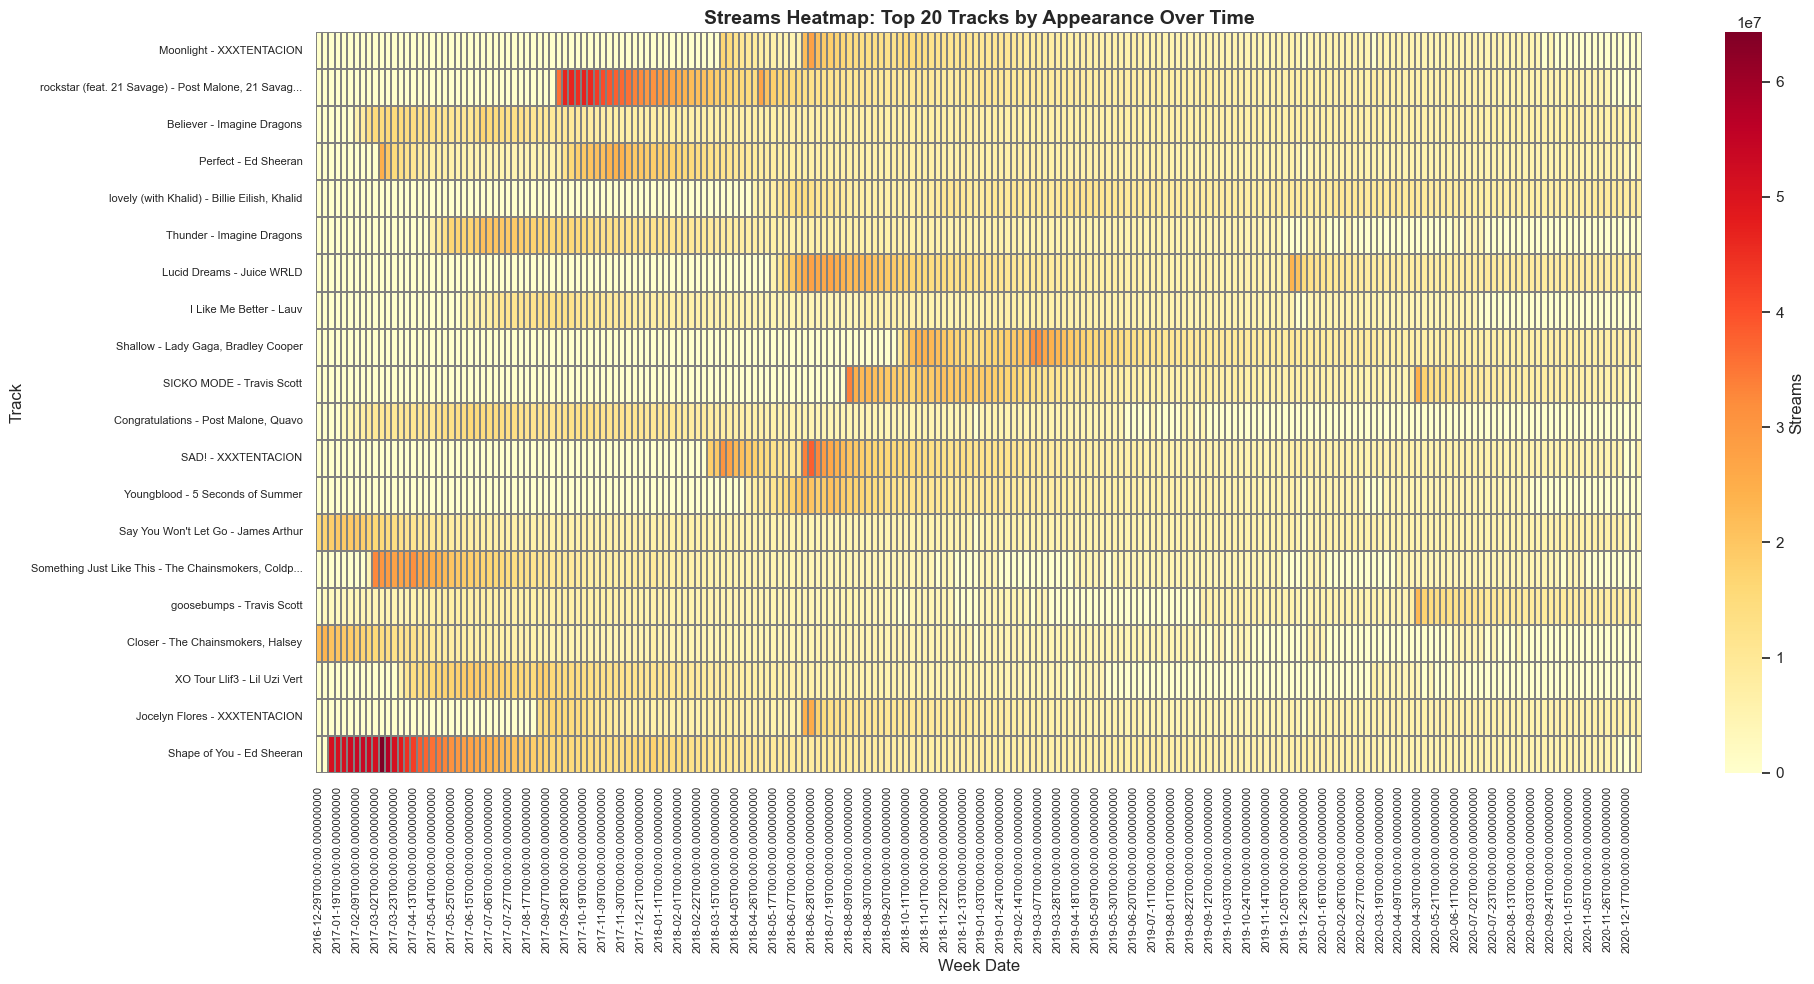

In [19]:
# Heatmap: Streams by track and week (for top 20 tracks by appearance)
plot_streams_heatmap(songs, track_appearances, top_n=20)


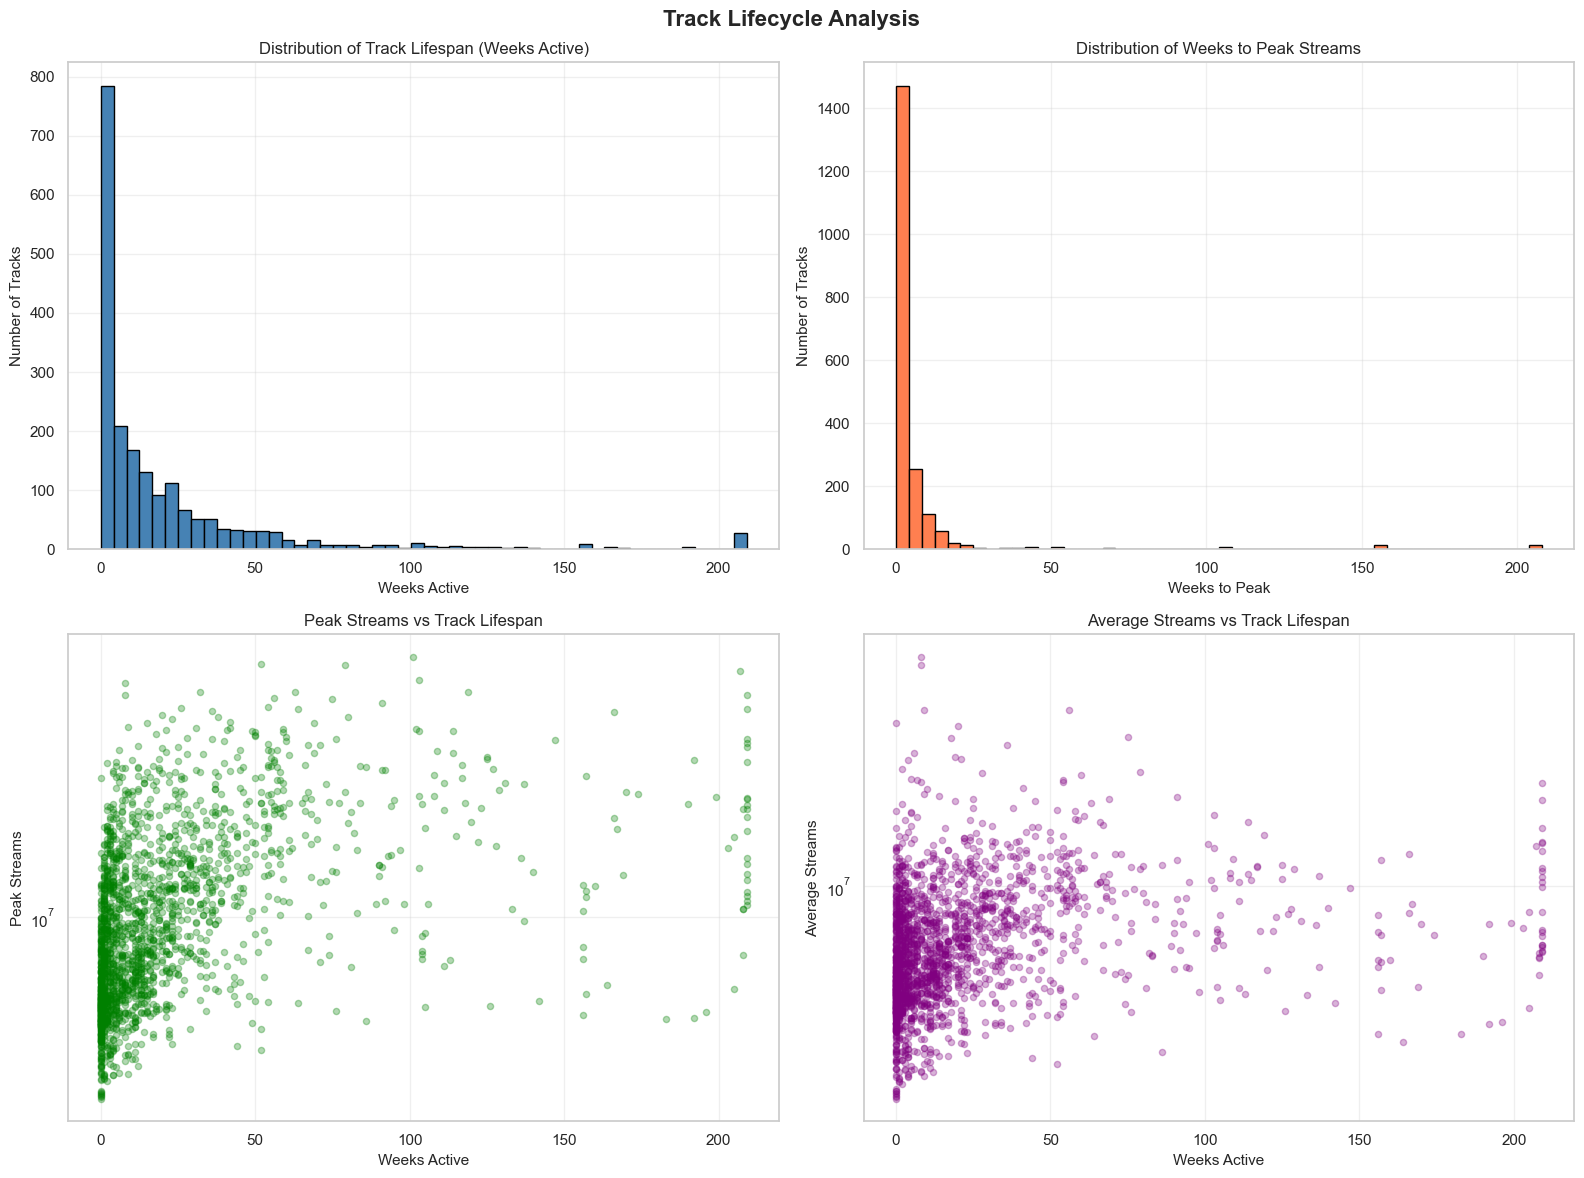


Track lifecycle statistics:
Average weeks active: 22.0
Median weeks active: 9.0
Average weeks to peak: 6.9
Median weeks to peak: 1.0


In [20]:
# Track lifecycle analysis: First appearance, peak, decline
track_lifecycle = calculate_track_lifecycle(songs)
plot_track_lifecycle(track_lifecycle)


# Key audio features for songs in the charts

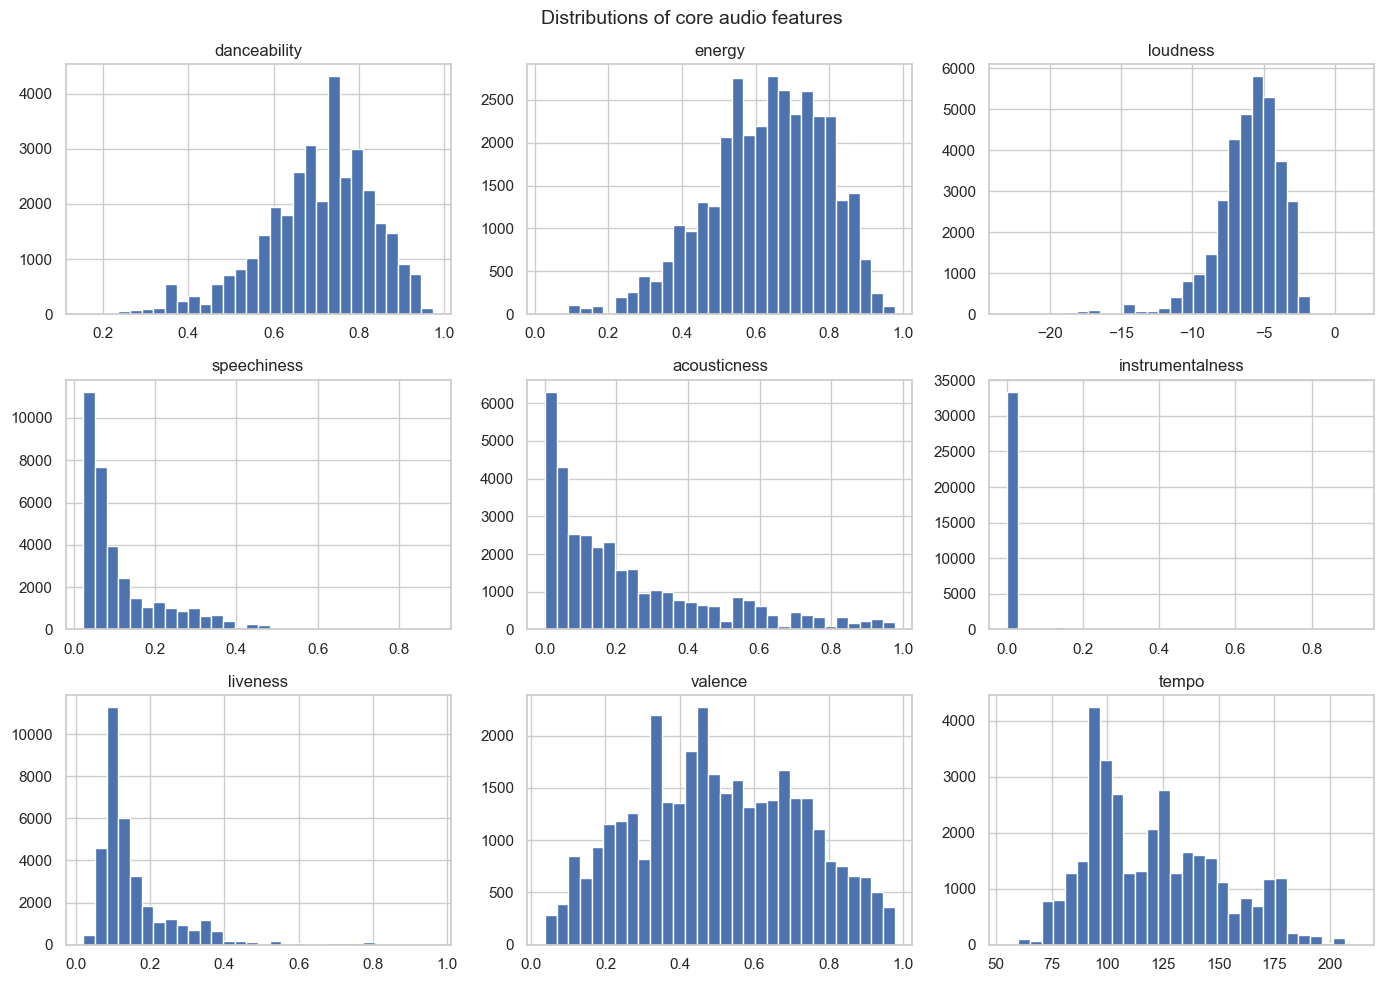

In [21]:
# Basic distribution plots for key audio features within the top songs
numeric_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

plot_audio_feature_distributions(songs, numeric_cols)


In [22]:
# Stream distribution by audio features
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']



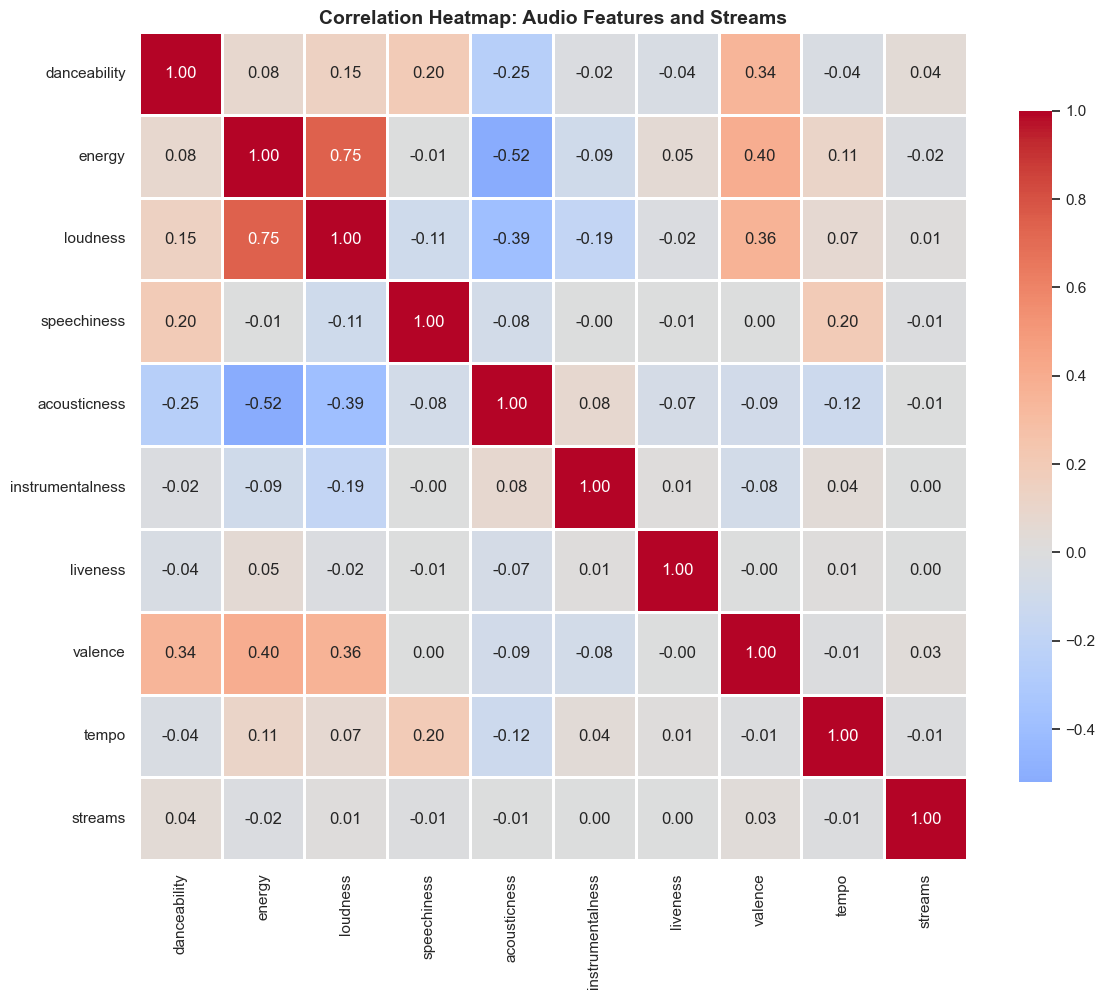


Top correlations with streams:
danceability        0.040631
valence             0.031191
loudness            0.012354
instrumentalness    0.002566
liveness            0.001698
acousticness       -0.007674
speechiness        -0.009800
tempo              -0.014455
energy             -0.016455
Name: streams, dtype: float64


In [23]:
# Correlation heatmap between audio features and streams
plot_correlation_heatmap(songs, audio_features)

# Show top correlations with streams
stream_correlations = get_stream_correlations(songs, audio_features)
print("\nTop correlations with streams:")
print(stream_correlations)


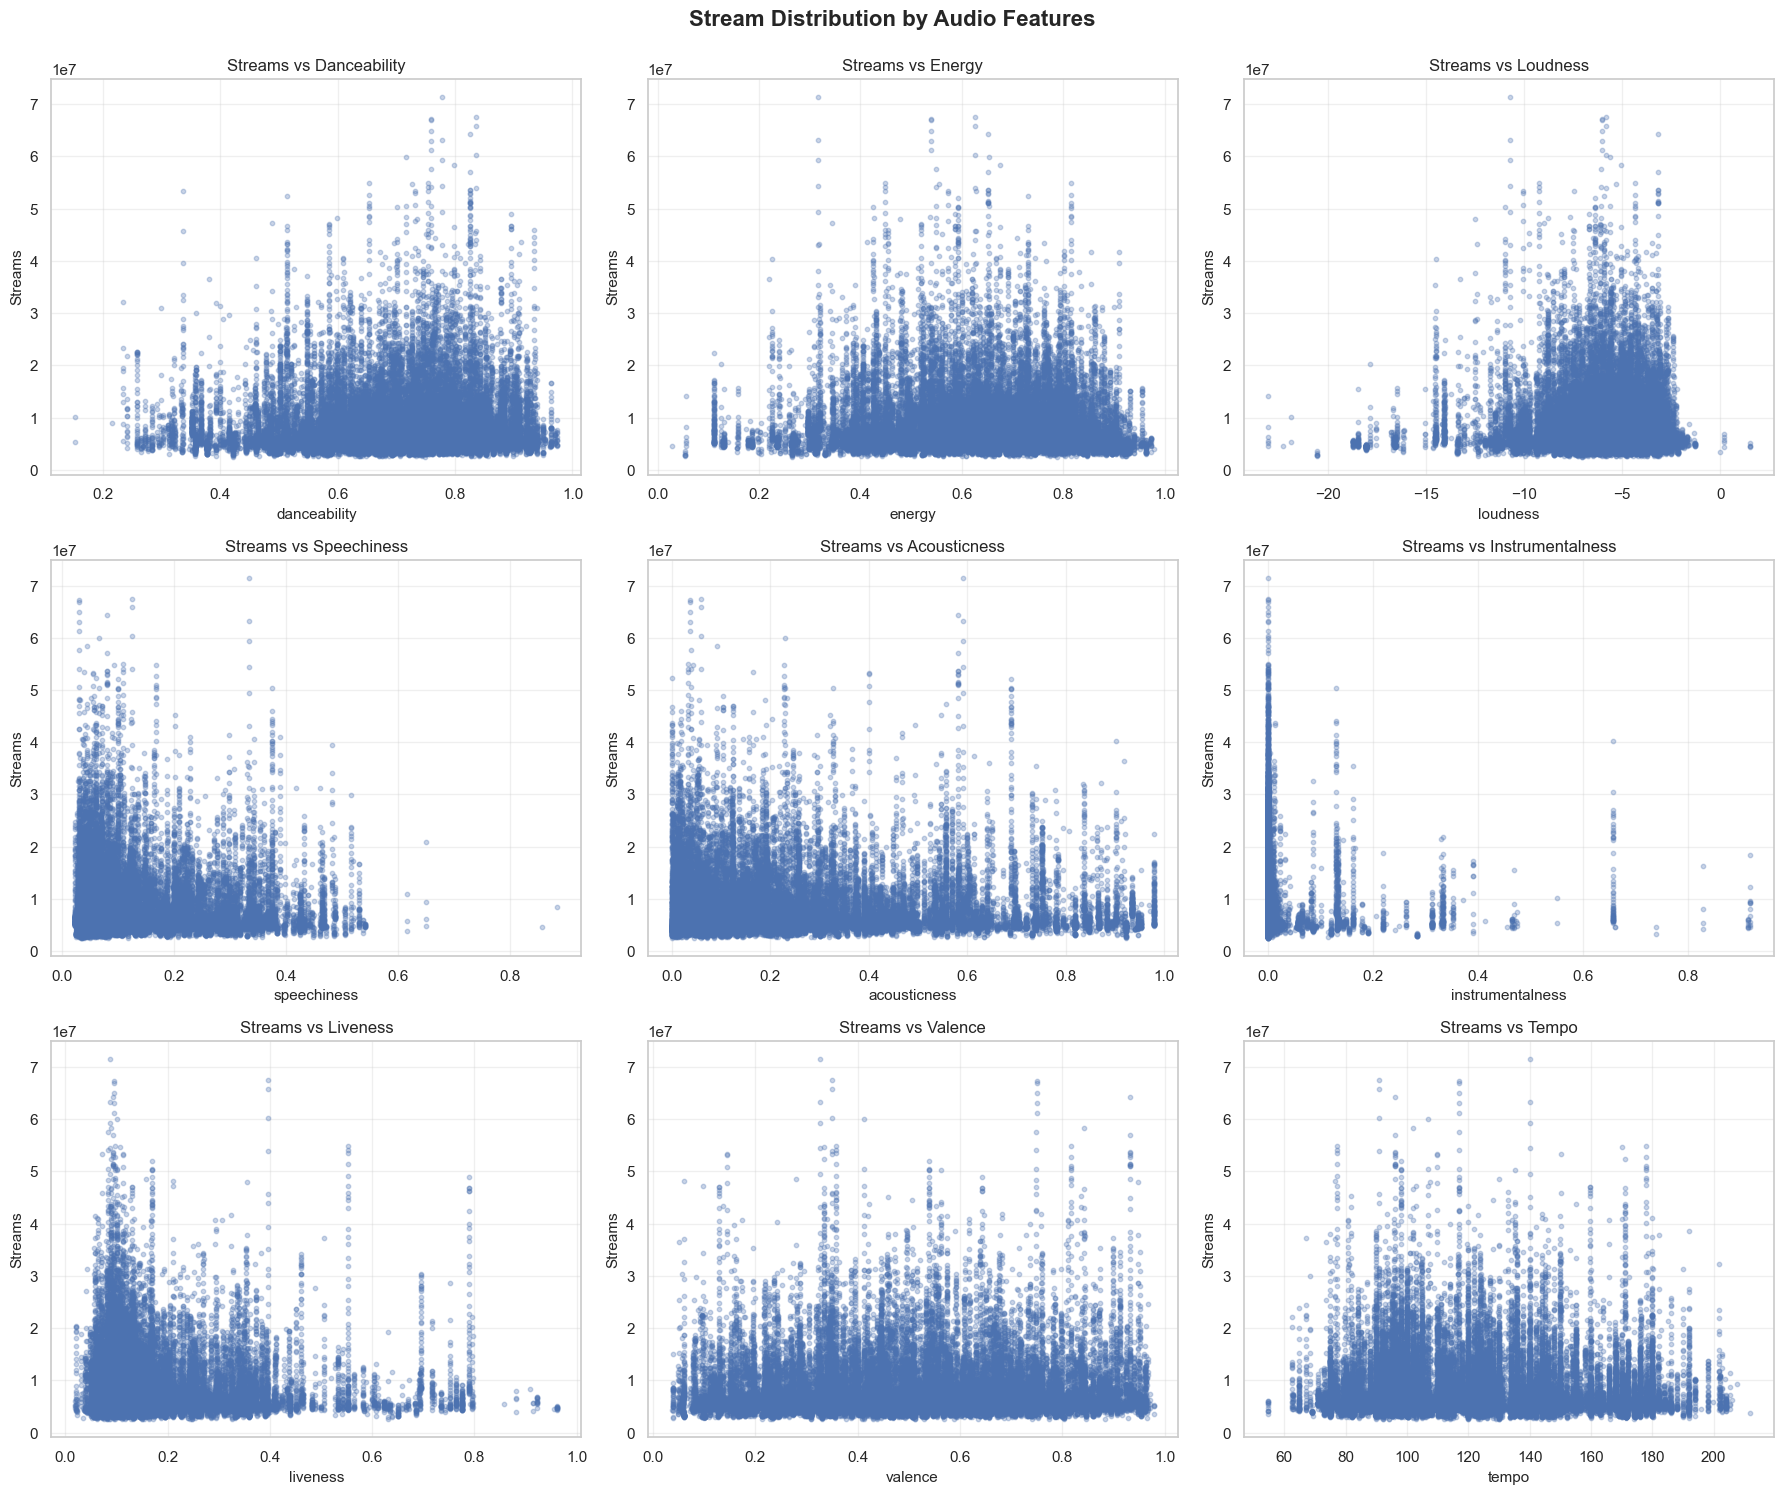

In [24]:

plot_streams_vs_features(songs, audio_features)


# Key Insights